In [10]:
from PIL import Image
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from functools import reduce
from random import randint
import math
import time
import cv2
from numba import jit, float32

In [40]:
image_path = 'D:/Labs KPI/Labs Pattern recognition 2021/Tau.jpg'
image = Image.open(image_path)
image = cv2.imread(image_path)
image = cv2.resize(image,(256,256))

In [49]:
@jit(nopython=True)
def multivariate_normall(x, mu1, cov1, mu2, cov2):
    size = len(x)
    pdf_1=(1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(np.linalg.det(cov1),1.0/2)))*math.pow(math.e, -0.5 * ((x - mu1).dot(np.linalg.inv(cov1)).dot((x - mu1).T)))
    pdf_2=(1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(np.linalg.det(cov2),1.0/2)))*math.pow(math.e, -0.5 * ((x - mu2).dot(np.linalg.inv(cov2)).dot((x - mu2).T)))
    return randint(0, 1), pdf_1, pdf_2

@jit(nopython=True)
def functions(image, p_k1, p_k2, mu_1, mu_2, cov_1, cov_2, shape, length):
    alpha_matrix  = np.zeros(shape=(*shape, 2), dtype=float32)
    alpha_1_sum = 0
    alpha_2_sum = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            _, like_1, like_2 = multivariate_normall(image[i][j], mu_1, cov_1, mu_2, cov_2)
            alpha_1 = (p_k1 * like_1)/((p_k1 * like_1) + (p_k2 * like_2))
            alpha_2 = (p_k2 * like_2)/((p_k1 * like_1) + (p_k2 * like_2))
            alpha_matrix[i][j] = alpha_1, alpha_2
            alpha_1_sum = alpha_1_sum + alpha_1
            alpha_2_sum = alpha_2_sum + alpha_2
    p_k1 = alpha_1_sum/(shape[0]*shape[1])
    p_k2 = alpha_2_sum/(shape[0]*shape[1])
    for r in range(length):
        mu_1[r] = np.sum(alpha_matrix[:, :, 0]*image[:, :, r])/alpha_1_sum
        mu_2[r] = np.sum(alpha_matrix[:, :, 1]*image[:, :, r])/alpha_2_sum
        for s in range(length):
            cov_1[r, s] = np.sum(alpha_matrix[:, :, 0]*(image[:, :, r]-mu_1[r])*(image[:, :, s]-mu_1[s]))/alpha_1_sum
            cov_2[r, s] = np.sum(alpha_matrix[:, :, 1]*(image[:, :, r]-mu_2[r])*(image[:, :, s]-mu_2[s]))/alpha_2_sum
    return mu_1, mu_2, cov_1, cov_2, p_k1, p_k2

@jit(nopython=True)
def get_neighbors(grid, x, y):
    out = []
    if x > 0:
        out.append(grid[x-1, y,0])
    if y > 0:
        out.append(grid[x, y-1,0])
    if y < grid.shape[1] - 1:
        out.append(grid[x, y+1,0])
    if x < grid.shape[0] - 1:
        out.append(grid[x+1, y,0])
    return out

@jit(nopython=True)
def sampler(massive, shape):
    eps = 0.2
    for i in range(shape[0]):
        for j in range(shape[1]):
            neighbors = get_neighbors(massive,i,j)
            k1 = massive[i, j][1]
            k2 = massive[i, j][2]
            for k in neighbors:
                if(k == 1):
                    k1 = k1*(1-eps)
                else:
                    k1 = k1*eps
                if(k == 0):
                    k2 = k2*(1-eps)
                else:
                    k2 = k2*eps
            prob_k1, prob_k2 = k1 / (k1 + k2), k2 / (k1 + k2)
            if(prob_k1 > prob_k2):
                massive[i, j, 0] = 1
            else:
                massive[i, j, 0] = 0
            massive[i, j, 1:] = prob_k1, prob_k2
    return massive


def EM(image, em_iters=100):
    shape = image.shape
    p_k1 = 1/2.
    p_k2 = 1/2.
    mu_1 = np.array([0,0,0], dtype=np.float64)
    mu_2 = np.array([200,170,200], dtype=np.float64)
    cov_1 = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)
    cov_2 = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)
    for iteration in range(em_iters):
        #t = time.process_time()
        #print('iters number', iteration)
        mu_1, mu_2, cov_1, cov_2, p_k1, p_k2 = functions(image, p_k1, p_k2, mu_1, mu_2, cov_1, cov_2, shape[:2], shape[2])
        #print(time.process_time() - t)
    matrix = np.zeros(shape=shape, dtype=float)
    for i in range(shape[0]):
        for j in range(shape[1]):
            matrix[i, j] = multivariate_normall(image[i][j], mu_1, cov_1, mu_2, cov_2)
    for i in range(em_iters):
        matrix = sampler(matrix, shape)
    return matrix[:, :, 0] 

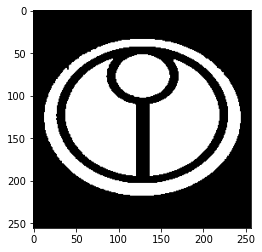

19.34375


In [50]:
t = time.process_time()
marked_image_data = EM(image, 100)
marked_image_data = np.expand_dims(marked_image_data, axis=2)
marked_image_data = np.tile(marked_image_data, (1, 1, 3))
plt.imshow(marked_image_data)
plt.show()
print(time.process_time() - t)